In [ ]:
import tensorflow as tf
import numpy as np
from numpy.random import default_rng
import time

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

np.random.seed(1)
%matplotlib inline

## Preparamos el conjunto de datos de Cross Sections

In [ ]:
rng = default_rng()

In [ ]:
def loguni(min_val, max_val, size): #Genera distribución aleatoria logaritmicamente uniforme
    return np.exp((np.log(max_val) -np.log(min_val)) * rng.random(size)) + min_val

In [ ]:
#"constantes" (acoplamientos y masas en MeV)
alpha = 1/137.035999084 #Constante de estructura fina
alpha_s = 0.1185 #Acoplamiento fuerte, a M_Z
m_e = 0.511 #Masa de electrón
m_mu = 105.6#Masa de muón
m_tau = 1776.86 #lo que dice
m_u = 1.288
m_d = 2.751
m_ch = 6.268e2
m_st = 5.432e1
m_t = 171.68e3
m_b = 2.854e3
m_p = 938.28
m_higgs = 125.10 #Masa del Higgs

In [ ]:
# Produccion de fermiones por e+e- a leading order
#Electrón producción de fermione por e+ e-
def e_mu(th, s): #0
    E2 = s/4 #s = 4E^2
    A = m_mu**2/E2
    B = (E2-m_mu**2)/(E2-m_e**2)
    C = (m_e**2+m_mu**2)/E2
    return (alpha/(16*E2))*np.sqrt(B)*(1+C+(1-A)*np.cos(th)**2)

def e_tau(th, s): #1
    E2 = s/4 #s = 4E^2
    A = m_tau**2/E2
    B = (E2-m_tau**2)/(E2-m_e**2)
    C = (m_e**2+m_tau**2)/E2
    return (alpha/(16*E2))*np.sqrt(B)*(1+C+(1-A)*np.cos(th)**2)

def e_u(th, s): #2
    E2 = s/4 #s = 4E^2
    A = m_u**2/E2
    B = (E2-m_u**2)/(E2-m_e**2)
    C = (m_e**2+m_u**2)/E2
    return 3*(2/3)**2*(alpha/(16*E2))*np.sqrt(B)*(1+C+(1-A)*np.cos(th)**2)

def e_d(th, s): #3
    E2 = s/4 #s = 4E^2
    A = m_d**2/E2
    B = (E2-m_d**2)/(E2-m_e**2)
    C = (m_e**2+m_d**2)/E2
    return 3*(1/3)**2*(alpha/(16*E2))*np.sqrt(B)*(1+C+(1-A)*np.cos(th)**2)

def e_ch(th, s): #4
    E2 = s/4 #s = 4E^2
    A = m_ch**2/E2
    B = (E2-m_ch**2)/(E2-m_e**2)
    C = (m_e**2+m_ch**2)/E2
    return 3*(2/3)**2*(alpha/(16*E2))*np.sqrt(B)*(1+C+(1-A)*np.cos(th)**2)

def e_st(th, s): #5
    E2 = s/4 #s = 4E^2
    A = m_st**2/E2
    B = (E2-m_st**2)/(E2-m_e**2)
    C = (m_e**2+m_st**2)/E2
    return 3*(1/3)**2*(alpha/(16*E2))*np.sqrt(B)*(1+C+(1-A)*np.cos(th)**2)

def mu_tau(th, s): #6
    E2 = s/4 #s = 4E^2
    A = m_tau**2/E2
    B = (E2-m_tau**2)/(E2-m_mu**2)
    C = (m_mu**2+m_tau**2)/E2
    return (alpha/(16*E2))*np.sqrt(B)*(1+C+(1-A)*np.cos(th)**2)

def e_t(th, s): #7
    E2 = s/4 #s = 4E^2
    A = m_t**2/E2
    B = (E2-m_t**2)/(E2-m_e**2)
    C = (m_e**2+m_t**2)/E2
    return 3*(2/3)**2*(alpha/(16*E2))*np.sqrt(B)*(1+C+(1-A)*np.cos(th)**2)

def e_b(th, s): #8
    E2 = s/4 #s = 4E^2
    A = m_b**2/E2
    B = (E2-m_b**2)/(E2-m_e**2)
    C = (m_e**2+m_b**2)/E2
    return 3*(1/3)**2*(alpha/(16*E2))*np.sqrt(B)*(1+C+(1-A)*np.cos(th)**2)

In [ ]:
#Otros procesos de QED a leading order
#https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/theoretical-physics/msc/current/qft/handouts/qftcrossection.pdf
def Yukawa(th, s): #9
    # ESTE ES DE DOS CUERPOS a uno y es artificial
    E2 = s/4 #s = 4E^2
    m = m_higgs #Ponemos masa del higgs como la del bosón de interacción
    M = m_e #Masa del electrón como la del par de partículas que interactúan
    g = 64*np.pi**2*alpha #Constante de acoplamiento artificial
    p2 = E2-M**2
    A = 2*p2*(1+np.cos(th))+m**2
    B = 2*p2*(1-np.cos(th))+m**2
    return g**4/(128*np.pi**2*np.sqrt(E2))*(1/A+1/B)

#https://edu.itp.phys.ethz.ch/hs12/qft1/Chapter09.pdf (para los dos siguientes)
#Electrón con electrón (proceso de segundo orden)
def e_e(th, s): #10
    ep = 1e-8 #elimina polo no fisico
    E2 = s/4 #s = 4E^2
    m = m_e
    p2 = E2-m**2
    A = (4*p2+2*m**2)**2/(p2**2*np.sin(th)**4 + ep)
    B = (8*p2**2+12*m**2*p2+3*m**4)/(p2**2*np.sin(th)**4 + ep)
    return (alpha**2/(4*E2))*(A-B+1)

#Electrón con positrón (Rutherford)
def e_p(th, s): #11
    m1 = m_e
    m2 = m_e
    m3 = m_p
    m4 = m_p
    p1 = np.sqrt((s-(m1-m2)**2)*(s-(m1+m2)**2))/(2*np.sqrt(s))
    p3 = np.sqrt((s-(m3-m4)**2)*(s-(m3+m4)**2))/(2*np.sqrt(s))
    E1 = np.sqrt(m1**2 + p1**2)
    E3 = np.sqrt(m3**2 + p3**2)
    t = m1**2 + m3**2 - 2*E1*E3 + 2*p1*p3*np.cos(th)
    u = m1**2 + m2**2 + m3**2 + m4**2 - s - t
    A = ((s-u)/t+(t-u)/s)**2
    B = 16*m1**2*(5*m1**2-2*u)/(s*t)
    return (alpha**2/(4*s))*(A+B)

In [ ]:
FUNCTIONS = [e_mu,e_tau,e_u,e_d,e_ch,e_st,mu_tau,e_t,e_b,Yukawa,e_e,e_p] #Lista de las functiones

dic = {0: 'e_mu', 1: 'e_tau', 2: 'e_u', 3: 'e_d', 4: 'e_ch', 
       5: 'e_st', 6: 'mu_tau', 7:'e_t', 8: 'e_b', 9: 'Yukawa',
       10: 'e_e', 11: 'e_p'} #Diccionario con los nombres

MinE = [(2*m_mu)**2,(2*m_tau)**2,(2*m_u)**2,(2*m_d)**2,(2*m_ch)**2,
        (2*m_st)**2,(2*m_tau)**2,(2*m_t)**2,(2*m_b)**2,(2*m_e)**2,
        (2*m_e)**2,(2*m_p)**2] #Lista de energías mínimas (cada caso tiene una energía prohibida diferente)

In [ ]:
def data_gen(f, th0, l_s, s_min, s_max, sig_oom):
    l_th = len(th0)
    
    ph = np.sort(loguni(s_min, s_max, 2))
    
    ls_min = np.log(ph[0])
    ls_max = np.log(ph[1])
    
    s0 = np.logspace(ls_min, ls_max, l_s, base = np.e)
    
    ls_mean = np.log(np.mean(s0))
    ls_median = np.log(np.median(s0))
    ls_std = np.log(np.std(s0))
    
    th, s = np.meshgrid(th0, s0)
    
    f_val = f(th, s) 
    
    fs_min = np.log(f_val.min())
    fs_max = np.log(f_val.max())    
    fs_mean = np.log(np.mean(f_val))
    fs_median = np.log(np.median(f_val))
    fs_std = np.log(np.std(f_val))
    
    vec = np.array([ls_min, ls_max, ls_mean, ls_median, ls_std, fs_min, fs_max, fs_mean, fs_median, fs_std])
    
    dsigma = np.log(f_val*(1 + rng.normal(0, sig_oom, size=(l_th, l_s)))) #Escalamos logaritmicamente y agregamos ruido
    #dsigma = f_val*(1 + rng.normal(0, sig_oom, size=(l_th, l_s)))
    
    return np.array(dsigma), np.array(vec)

### Ejemplo de sección eficaz

In [ ]:
l = 32
th0 = np.linspace(-np.pi, np.pi, l)

i = 0 #Cambiar i desde 0 hasta 11 para las diferentes secciones eficaces
#Cada vez que se corra data_gen va a dar un rango de energías diferente
dsigma, vec = data_gen(FUNCTIONS[i], th0, l, MinE[i], 1e16, 0.05)

print(dsigma.shape) #dsigma es la "imágen" en 2D de la sección eficaz
print(vec.shape) #vec es un vector con propiedades estadísticas del rango de energías y del orden de magnitud de la sección eficaz

(32, 32)
(10,)


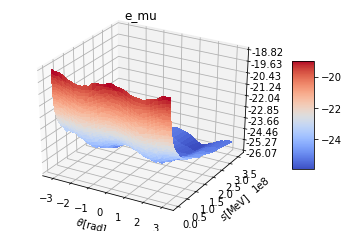

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
th, s = np.meshgrid(th0, np.logspace(vec[0], vec[1], l, base = np.e))

# Plot the surface.
surf = ax.plot_surface(th, s, dsigma, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(dsigma.min(), dsigma.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_title(dic[i])
ax.set_xlabel(r"$\theta$[rad]")
ax.set_ylabel(r"$s$[MeV]")

plt.show()

## Generamos la base de datos

In [ ]:
N = 1000 #Numero de muestras de cada cross section. La base total tendrá 12*N muestras
l = 32
th0 = np.linspace(-np.pi, np.pi, l) #Rango de ángulos fijo y global
x = []
v = []
y = []

for i in range(0,12):
  for n in range(0,N):
    dsigma, vec = data_gen(FUNCTIONS[i], th0, l, MinE[i], 1e16, 0.05)
    #Normalizamos cada sección eficaz individualmente (vec tiene la información del orden de magnitud)
    dsigma = (dsigma - np.mean(dsigma))/(np.std(dsigma) + 1e-8)
    #dsigma = (dsigma)/(np.std(dsigma) + 1e-8)
    x.append(dsigma)
    v.append(vec)
    y.append([i])

x = np.array(x)
x = np.expand_dims(x, axis=3) #Le agregamos un axis a x porque solo es un canal
v = np.array(v)
y = np.array(y)

#Normalizamos a cada entrada v como muestra total (se mantienen las proporciones de orden de magnitud)
v = (v - np.mean(v,axis=0))/(np.std(v,axis=0) + 1e-8)
#v = (v)/(np.std(v,axis=1) + 1e-8)

#Ponemos a y en formato one-hot enconde
y = np.eye(12)[y.reshape(-1)]

print(x.shape)
print(v.shape)
print(y.shape)

(12000, 32, 32, 1)
(12000, 10)
(12000, 12)


In [ ]:
#Mezclamos aleatoriamente las muestras y generamos conjuntos de train y val
L = len(x)
index = np.arange(0,L,1)
np.random.shuffle(index)

val_percent = 15 #Porcentaje de datos que se van a conjunto validación
cut = int(val_percent*L/100)

x_val = x[index][0:cut]
v_val = v[index][0:cut]
y_val = y[index][0:cut]

x_train = x[index][cut:]
v_train = v[index][cut:]
y_train = y[index][cut:]

print("VALIDATION SHAPE")
print(x_val.shape)
print(v_val.shape)
print(y_val.shape)
print("TRAIN SHAPE")
print(x_train.shape)
print(v_train.shape)
print(y_train.shape)

VALIDATION SHAPE
(1800, 32, 32, 1)
(1800, 10)
(1800, 12)
TRAIN SHAPE
(10200, 32, 32, 1)
(10200, 10)
(10200, 12)


In [ ]:
#Por ultimo cambiamos las variables a tensores constantes con el tipo de datos apropiado
TRAIN_x = tf.constant(x_train,dtype=tf.float32)
TRAIN_v = tf.constant(v_train,dtype=tf.float32)
TRAIN_y = tf.constant(y_train,dtype=tf.float32)

TEST_x = tf.constant(x_val,dtype=tf.float32)
TEST_v = tf.constant(v_val,dtype=tf.float32)
TEST_y = tf.constant(y_val,dtype=tf.float32)

## Definición con Tensorflow de los Módulos que utilizaremos

### Filtro convolucional en 2D

In [ ]:
#Módulo de convolución en 2D creado por mi
class Conv2D(tf.Module):
    def __init__(self, num_filters, dim_filters ,strides = None, padding="SAME", name="Conv2D"):
        super().__init__(name=name)
        self.num_filters = num_filters #Number of filters
        self.dim_filters = dim_filters #Dimension of each filter (tuple of length 2)
        self.strides = strides #stride of filters
        self.padding = padding #padding (VALID or SAME)
    
    def __call__(self, x, filters, b):
        #filters = tf.Variable(tf.random.normal([self.dim_filters[0],self.dim_filters[1],self.chan_in,self.num_filters]), name='filters')
        #b = tf.Variable(tf.zeros([self.num_filters]), name='b')
        return tf.nn.conv2d(x,filters,self.strides,self.padding) + b

### Batch normalization

In [ ]:
#Módulo de batch normalization 2D creado por mi
class BatchNormalization2D(tf.Module):
    def __init__(self, name="Batch_Normalization"):
        super().__init__(name=name)
    
    def __call__(self, x, gamma, beta):
        #chan_in = len(x[0][0][0])
        #beta = tf.Variable(tf.zeros([self.chan_in]), name='b') #un offset por cada canal de salida
        #gamma = tf.Variable(tf.ones([self.chan_in]), name='gamma') #un scale por cada canal de salida
        mean, variance = tf.nn.moments(x, axes=[0,1,2], shift=None, keepdims=False, name=None) #axes = [0,1] para 1D
        return tf.nn.batch_normalization(x, mean, variance, beta, gamma, variance_epsilon=1e-10)

### Average Pooling

In [ ]:
#Módulo de Average Pooling 2D creado por mi
class AvgPool2D(tf.Module):
    def __init__(self, dim_filter, strides = None, padding="VALID", name="Average_Pooling"):
        super().__init__(name=name)
        self.dim_filter = dim_filter #Dimension of each filter (2-tupla en 2D)
        self.strides = strides #stride of filters
        self.padding = padding #padding (VALID or SAME)
        self.ksize = [1,self.dim_filter[0],self.dim_filter[1],1] #Tamaño del kernel en 2D
    
    def __call__(self, x):
        return tf.nn.avg_pool(x, self.ksize, self.strides, self.padding, data_format=None)

### Max Pooling

In [ ]:
#Módulo de Max Pooling 2D creado por mi
class MaxPool2D(tf.Module):
    def __init__(self, dim_filter, strides = None, padding="VALID", name="Max_Pooling"):
        super().__init__(name=name)
        self.dim_filter = dim_filter #Dimension of each filter (2-tupla en 2D)
        self.strides = strides #stride of filters
        self.padding = padding #padding (VALID or SAME)
        self.ksize = [1,self.dim_filter[0],self.dim_filter[1],1] #Tamaño del kernel en 2D
    
    def __call__(self, x):
        return tf.nn.max_pool(x, self.ksize, self.strides, self.padding, data_format=None)

## Funciones de activación

In [ ]:
class Relu(tf.Module):
    def __init__(self, name="Relu"):
        super().__init__(name=name)
    
    def __call__(self, x):
        return tf.nn.relu(x, name=None)

class Elu(tf.Module):
    def __init__(self, name="Elu"):
        super().__init__(name=name)
    
    def __call__(self, x):
        return tf.nn.elu(x, name=None)

class SoftMax(tf.Module):
    def __init__(self, name="SoftMax"):
        super().__init__(name=name)
    
    def __call__(self, x):
        return tf.nn.softmax(x) #axis -1 por default

## Módulos de redes neuronales

### Flatten y Concatenate

In [ ]:
class Flatten(tf.Module):
    def __init__(self, name="Flatten"):
        super().__init__(name=name)
    
    def __call__(self, x):
        return tf.compat.v1.layers.Flatten()(x) #El primer paréntesis es para llamar a la función, el segundo es evaluarla en x

class Concat(tf.Module):
    def __init__(self, name="Concat"):
        super().__init__(name=name)
    
    def __call__(self, x1, x2):
        return tf.concat([x1,x2], axis=1) #Concatena dos vectores a lo largo de la última entrada

### Dense

In [ ]:
class Dense(tf.Module):
    # Note: No need for `in+features`
    def __init__(self, out_features, name="Dense"):
        super().__init__(name=name)
        self.out_features = out_features

    def __call__(self, x, w, b):
        return tf.nn.bias_add(tf.matmul(x, w),b)

## Funciones de costo y accuracy

In [ ]:
def Min_Cuad(target_y, predicted_y): #Minimos cuadrados
    return tf.reduce_mean(tf.square(target_y - predicted_y))

def Cat_Cross(target_y, predicted_y): #Categorical Crossentropy para modelo con softmax de salida
    return tf.losses.categorical_crossentropy(target_y ,predicted_y)

def Cat_Cross_Logits(target_y, predicted_y): #Categorical Crossentropy ya con softmax incluido (numéricamente mas estable)
    return tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(target_y),logits=predicted_y)
#Logits: "Unnormalized log probabilities"

def Accuracy(target_y,predicted_y):
  correct_prediction = tf.equal(tf.argmax(target_y, 1), tf.argmax(predicted_y, 1))
  return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Act = SoftMax()
def Accuracy_Logits(target_y,predicted_y): #Accuracy ya con softmax incluido (numéricamente mas estable)
  correct_prediction = tf.equal(tf.argmax(target_y, 1), tf.argmax(Act(predicted_y), 1))
  return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Haremos un objeto general para un modelo entrenable y con algunas propiedades útiles

In [ ]:
class TF_Model(tf.Module): #Hereda las propiedades de tf.Module, estructurado para tener entrada de imágenes y entrada de vectores que luego concatena
    def __init__(self):
        super().__init__()
        self.layers_x = layers_x #Capas de convolución de la imagen, debe tener como salida un vector
        self.layers_v = layers_v #Capas de red neuronal de la entrada vectorial adicional
        self.layers_c = layers_c #Capas de la concatenación del resultado de layers_x y layers_v
        self.history = [[],[],[],[]] #[[train_loss],[train_acuracy],[validation_loss],[validation_acuracy]]
        self.is_built = False

    def initialize(self, x, v):
      #Inicializa los filtros, pesos y biases con la dimensionalidad correcta
      #Si las capas están mal acomodadas en la función F, este proceso va a fallar
      self.input_example = (x, v)
      self.weights_x = []
      self.biases_x = []
      self.weights_v = []
      self.biases_v = []
      self.weights_c = []
      self.biases_c = []
      i = 0
      for layer in self.layers_x: #Capas en x
        if layer.name == "Average_Pooling" or layer.name == "Max_Pooling" or layer.name == "Relu" or layer.name == "Elu" or layer.name == "SoftMax" or layer.name == "Flatten" or layer.name == "Dropout":
          x = layer(x)
        elif layer.name == "Conv2D":
          #Matriz con (num_filters) de filtros con dimensión (dim_filters) con valores iniciales random
          self.weights_x.append(tf.Variable(tf.random.normal([layer.dim_filters[0],layer.dim_filters[1],len(x[0][0][0]),layer.num_filters]), name='filters', trainable=True))
          self.biases_x.append(tf.Variable(tf.zeros([layer.num_filters]), name='b', trainable=True)) #un bias por cada canal de salida
          x = layer(x,self.weights_x[i],self.biases_x[i])
          i+=1
        elif layer.name == "Batch_Normalization":
          chan_in = len(x[0][0][0])
          self.biases_x.append(tf.Variable(tf.zeros([chan_in]), name='beta', trainable=True)) #un offset por cada canal de salida
          self.weights_x.append(tf.Variable(tf.ones([chan_in]), name='gamma', trainable=True)) #un scale por cada canal de salida
          x = layer(x,self.weights_x[i],self.biases_x[i])
          i+=1
        elif layer.name == "Dense":
          self.weights_x.append(tf.Variable(tf.random.normal([x.shape[-1], layer.out_features]), name='w', trainable=True))
          self.biases_x.append(tf.Variable(tf.zeros([layer.out_features]), name='b', trainable=True))
          x = layer(x,self.weights_x[i],self.biases_x[i])
          i+=1
        else:
          print("ERROR: Nombre de capa no reconocido: ")
          print(layer.name)

      i = 0
      for layer in self.layers_v: #Capas en v
        if layer.name == "Relu" or layer.name == "Elu" or layer.name == "SoftMax" or layer.name == "Dropout":
          v = layer(v)
        elif layer.name == "Dense":
          self.weights_v.append(tf.Variable(tf.random.normal([v.shape[-1], layer.out_features]), name='w', trainable=True))
          self.biases_v.append(tf.Variable(tf.zeros([layer.out_features]), name='b', trainable=True))
          v = layer(v,self.weights_v[i],self.biases_v[i])
          i+=1
        else:
          print("ERROR: Nombre de capa no reconocido: ")
          print(layer.name)

      c = tf.concat([x,v], axis=1)
      i = 0
      for layer in self.layers_c: #Capas en v
        if layer.name == "Relu" or layer.name == "Elu" or layer.name == "SoftMax" or layer.name == "Dropout":
          c = layer(c)
        elif layer.name == "Dense":
          self.weights_c.append(tf.Variable(tf.random.normal([c.shape[-1], layer.out_features]), name='w', trainable=True))
          self.biases_c.append(tf.Variable(tf.zeros([layer.out_features]), name='b', trainable=True))
          c = layer(c,self.weights_c[i],self.biases_c[i])
          i+=1
        else:
          print("ERROR: Nombre de capa no reconocido: ")
          print(layer.name)

      self.is_built = True
    
    def trainable_variables(self):
      return self.weights_x + self.weights_v + self.weights_c + self.biases_x + self.biases_v + self.biases_c

    def trainable_parameters(self):
      t_par = 0
      for var in self.trainable_variables():
        t_par += var.numpy().size
      return t_par
    
    def summary(self):
        if not self.is_built:
            print("Error: No has inicializado las variables")
        else:
            x, v = self.input_example
            s = " "
            space = 25
            print("Model: CNN (entry x) with Lateral Neural Network (entry v) with "+str(len(self.layers_x)+len(self.layers_v)+len(self.layers_c))+" total layers.")
            
            shapex_str = ""
            for n in x.shape[1:]:
                shapex_str += ", "+str(n)
            print("")
            print("CONVOLUTIONAL NEURAL NETWORK")
            print("Input shape x: (Batch"+shapex_str+")")
            print(75*"-")
            print("Layer"+(space-5)*s+"Output shape"+(space-12)*s+"Trainable paramaterers")
            print(75*"=")
            i = 0
            for layer in self.layers_x:
                if layer.name == "Conv2D" or layer.name == "Batch_Normalization" or layer.name == "Dense":
                  x = layer(x,self.weights_x[i],self.biases_x[i])
                  t_param_layer = self.weights_x[i].numpy().size+self.biases_x[i].numpy().size
                  i += 1
                else:
                  x = layer(x)
                  t_param_layer = 0
                shapex_str = ""
                for n in x.shape[1:]:
                    shapex_str += ", "+str(n)
                print(layer.name+(space-len(layer.name))*s+"(Batch"+shapex_str+")"+(space+3-len(shapex_str))*s+str(t_param_layer))
                print(75*"-")

            shapev_str = ""
            for m in v.shape[1:]:
                shapev_str += ", "+str(m)
            print("")
            print("LATERAL NEURAL NETWORK")
            print("Input shape v: (Batch"+shapev_str+")")
            print(75*"-")
            print("Layer"+(space-5)*s+"Output shape"+(space-12)*s+"Trainable paramaterers")
            print(75*"=")
            i = 0
            for layer in self.layers_v:
                if layer.name == "Conv2D" or layer.name == "Batch_Normalization" or layer.name == "Dense":
                  v = layer(v,self.weights_v[i],self.biases_v[i])
                  t_param_layer = self.weights_v[i].numpy().size+self.biases_v[i].numpy().size
                  i += 1
                else:
                  v = layer(v)
                  t_param_layer = 0
                shapev_str = ""
                for m in v.shape[1:]:
                    shapev_str += ", "+str(m)
                print(layer.name+(space-len(layer.name))*s+"(Batch"+shapev_str+")"+(space+3-len(shapev_str))*s+str(t_param_layer))
                print(75*"-")

            print("")
            print("CONCATENATION")
            c = tf.concat([x,v], axis=1)
            shapec_str = ""
            shapec_str += ", "+str(n+m)
            print("c = Conc[(Batch"+shapex_str+"),(Batch"+shapev_str+")]")
            print("Input shape c: (Batch"+shapec_str+")")
            print(75*"-")
            print("Layer"+(space-5)*s+"Output shape"+(space-12)*s+"Trainable paramaterers")
            print(75*"=")
            i = 0
            for layer in self.layers_c:
                if layer.name == "Conv2D" or layer.name == "Batch_Normalization" or layer.name == "Dense":
                  c = layer(c,self.weights_c[i],self.biases_c[i])
                  t_param_layer = self.weights_c[i].numpy().size+self.biases_c[i].numpy().size
                  i += 1
                else:
                  c = layer(c)
                  t_param_layer = 0
                shapec_str = ""
                for m in c.shape[1:]:
                    shapec_str += ", "+str(m)
                print(layer.name+(space-len(layer.name))*s+"(Batch"+shapec_str+")"+(space+3-len(shapec_str))*s+str(t_param_layer))
                print(75*"-")

            print("Total trainable parameters: "+str(self.trainable_parameters()))

    def compile(self, optimizer="Adam_optimizer", loss=Cat_Cross, metrics=Accuracy):
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        self.compiled = True
        
    def batch_train(self, x, v, y, b, tot_b):
        with tf.GradientTape() as t:
          # Trainable variables are automatically tracked by GradientTape
          predicted = self(x,v)
          current_loss = self.loss(y, predicted)
          grads = t.gradient(current_loss, self.trainable_variables())
        
          if self.optimizer =="Adam_optimizer":
            Adam_optimizer.apply_gradients(zip(grads, self.trainable_variables()))
            train_loss = tf.reduce_mean(current_loss).numpy()
            train_ac = self.metrics(y, predicted).numpy()
          elif self.optimizer =="Gradient":
            print("Mejorar (usar grads de afuera)")
            #for var in self.trainable_variables():
            #    d_var = t.gradient(current_loss, var)
            #    var.assign_sub(learning_rate*d_var)
          else:
            print("ERROR: Optimizador no reconocido")

        return train_loss, train_ac

    
    def train(self,train_x,train_v,train_y,test_x,test_v,test_y,epochs,batch_size):
      if not self.compiled:
        print("ERROR: Se necesita compilar el modelo.")
      #Hacemos a x, y objetos tipo Dataset con algunas funcionalidades y optimizaciones
      TRAIN_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_v,train_y))

      for epoch in range(epochs):
        start_time = time.time()
        print("Epoch: "+str(epoch+1))
        train_ac = 0
        train_loss = 0

        # En cada época aplicamos un shuffle en 1024 elementos y separamos en batches de batch_size
        train_dataset = TRAIN_dataset.shuffle(buffer_size=1024).batch(batch_size)
        tot_b = train_dataset.cardinality().numpy()
        b = 0

        for batch in train_dataset:
          b+=1
          # Update the model with the batch
          batch_train_loss, batch_train_ac = self.batch_train(batch[0], batch[1], batch[2], b, tot_b)
          train_loss += batch_train_loss
          train_ac += batch_train_ac
          print("\rBatch: "+str(b)+"/"+str(tot_b)+", train loss = %2.5f" %(batch_train_loss)+", train acuracy: %2.6f" %(batch_train_ac), end="")
        train_loss, train_ac = train_loss/tot_b, train_ac/tot_b
        print("\rBatch: "+str(b)+"/"+str(tot_b)+", train loss = %2.5f" %(train_loss)+", train acuracy: %2.6f" %(train_ac), end="")
        
        val_ac = self.metrics(test_y,self(test_x,test_v)).numpy()
        val_loss = tf.reduce_mean(self.loss(test_y, self(test_x,test_v))).numpy()
        print(", validation loss = %2.5f" %(val_loss)+", validation acuracy: %2.6f" %(val_ac))
        print("Epoch training time: %.5f seconds" % (time.time() - start_time))
        self.history[0].append(train_loss)
        self.history[1].append(train_ac)
        self.history[2].append(val_loss)
        self.history[3].append(val_ac)

In [ ]:
#CAPAS DE x
Conv_1 = Conv2D(num_filters = 32, dim_filters = (3,3), strides = (1,1), padding="SAME")
Act_1 = Elu()
BNorm_1 = BatchNormalization2D()
Conv_2 = Conv2D(num_filters = 32, dim_filters = (3,3), strides = (1,1), padding="SAME")
Act_2 = Elu()
BNorm_2 = BatchNormalization2D()
MaxP_1 = MaxPool2D(dim_filter = (2,2), strides = (2,2), padding="VALID")
Drop_1 = tf.compat.v1.layers.Dropout(rate=0.2, name="Dropout")

Conv_3 = Conv2D(num_filters = 64, dim_filters = (3,3), strides = (1,1), padding="SAME")
Act_3 = Elu()
BNorm_3 = BatchNormalization2D()
Conv_4 = Conv2D(num_filters = 64, dim_filters = (3,3), strides = (1,1), padding="SAME")
Act_4 = Elu()
BNorm_4 = BatchNormalization2D()
MaxP_2 = MaxPool2D(dim_filter = (2,2), strides = (2,2), padding="VALID")
Drop_2 = tf.compat.v1.layers.Dropout(rate=0.3, name="Dropout")

Conv_5 = Conv2D(num_filters = 128, dim_filters = (3,3), strides = (1,1), padding="SAME")
Act_5 = Elu()
BNorm_5 = BatchNormalization2D()
Conv_6 = Conv2D(num_filters = 128, dim_filters = (3,3), strides = (1,1), padding="SAME")
Act_6 = Elu()
BNorm_6 = BatchNormalization2D()
MaxP_3 = MaxPool2D(dim_filter = (2,2), strides = (2,2), padding="VALID")
Drop_3 = tf.compat.v1.layers.Dropout(rate=0.4, name="Dropout")

Flat = Flatten()
Den_x = Dense(out_features = 10)
Act_x = Elu()

layers_x = [Conv_1, Act_1, BNorm_1, Conv_2, Act_2, BNorm_2, MaxP_1, Drop_1, Conv_3, Act_3, BNorm_3, Conv_4, Act_4, BNorm_4,
            MaxP_2, Drop_2, Conv_5, Act_5, BNorm_5, Conv_6, Act_6, BNorm_6, MaxP_3, Drop_3, Flat, Den_x, Act_x]

#CAPAS DE v
Den_1 = Dense(out_features = 5)
Act_1 = Elu()
#Drop_1 = tf.compat.v1.layers.Dropout(rate=0.1, name="Dropout")
Den_2 = Dense(out_features = 5)
Act_2 = Elu()
#Drop_2 = tf.compat.v1.layers.Dropout(rate=0.1, name="Dropout")
layers_v = [Den_1,Act_1,Den_2,Act_2]

#CAPAS DE c (la capa de concatenación está ya incluida dentro de la función)
Den_3 = Dense(out_features = 10)
Act_3 = Elu()
#Drop_3 = tf.compat.v1.layers.Dropout(rate=0.1, name="Dropout")
Den_4 = Dense(out_features = 12)
#Act_4 = SoftMax()
layers_c = [Den_3, Act_3, Den_4]


In [ ]:
class Function(TF_Model):
  def __init__(self, layers_x, layers_v, layers_c):
        super().__init__()
        self.layers_x = layers_x
        self.layers_v = layers_v
        self.layers_c = layers_c
        
  def __call__(self, x, v):
        #Insertamos las capas con sus nombres y entradas acomodados manualmente. Esto para optimización del entrenamiento.
        #CAPAS DE x
        x = Conv_1(x,self.weights_x[0],self.biases_x[0])
        x = Act_1(x)
        x = BNorm_1(x,self.weights_x[1],self.biases_x[1])
        x = Conv_2(x,self.weights_x[2],self.biases_x[2])
        x = Act_2(x)
        x = BNorm_2(x,self.weights_x[3],self.biases_x[3])
        x = MaxP_1(x)
        x = Drop_1(x)
        
        x = Conv_3(x,self.weights_x[4],self.biases_x[4])
        x = Act_3(x)
        x = BNorm_3(x,self.weights_x[5],self.biases_x[5])
        x = Conv_4(x,self.weights_x[6],self.biases_x[6])
        x = Act_4(x)
        x = BNorm_4(x,self.weights_x[7],self.biases_x[7])
        x = MaxP_2(x)
        x = Drop_2(x)

        x = Conv_5(x,self.weights_x[8],self.biases_x[8])
        x = Act_5(x)
        x = BNorm_5(x,self.weights_x[9],self.biases_x[9])
        x = Conv_6(x,self.weights_x[10],self.biases_x[10])
        x = Act_6(x)
        x = BNorm_6(x,self.weights_x[11],self.biases_x[11])
        x = MaxP_3(x)
        x = Drop_3(x)

        x = Flat(x)
        x = Den_x(x,self.weights_x[12],self.biases_x[12])
        x = Act_x(x)

        #CAPAS DE v
        v = Den_1(v,self.weights_v[0],self.biases_v[0])
        v = Act_1(v)
        #v = Drop_1(v)
        v = Den_2(v,self.weights_v[1],self.biases_v[1])
        v = Act_2(v)
        #v = Drop_2(v)

        #CONCATENACIÓN
        c = tf.concat([x,v], axis=1)

        #CAPAS DE c
        c = Den_3(c,self.weights_c[0],self.biases_c[0])
        c = Act_3(c)
        #c = Drop_3(c)
        c = Den_4(c,self.weights_c[1],self.biases_c[1])
        #c = Act_4(c)

        return c

My_Model = Function(layers_x,layers_v,layers_c)

In [ ]:
#Batch de prueba
ej_x = TRAIN_x[0:100]
ej_v = TRAIN_v[0:100]
ej_y = TRAIN_y[0:100]

In [ ]:
My_Model.initialize(ej_x,ej_v) #Inicializamos las variables automáticamente

start_time = time.time()
My_Model(ej_x,ej_v) #Tiempo de cómputo del Batch de prueba
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.010161638259887695 seconds ---


In [ ]:
My_Model.summary()

Model: CNN (entry x) with Lateral Neural Network (entry v) with 34 total layers.

CONVOLUTIONAL NEURAL NETWORK
Input shape x: (Batch, 32, 32, 1)
---------------------------------------------------------------------------
Layer                    Output shape             Trainable paramaterers
Conv2D                   (Batch, 32, 32, 32)                320
---------------------------------------------------------------------------
Elu                      (Batch, 32, 32, 32)                0
---------------------------------------------------------------------------
Batch_Normalization      (Batch, 32, 32, 32)                64
---------------------------------------------------------------------------
Conv2D                   (Batch, 32, 32, 32)                9248
---------------------------------------------------------------------------
Elu                      (Batch, 32, 32, 32)                0
---------------------------------------------------------------------------
Batch_Norm

In [ ]:
Adam_optimizer = tf.optimizers.Adam(learning_rate = 0.001)
My_Model.compile(optimizer="Adam_optimizer", loss=Cat_Cross_Logits, metrics=Accuracy_Logits) #Compilamos el modelo

In [ ]:
My_Model.train(TRAIN_x,TRAIN_v,TRAIN_y,TEST_x,TEST_v,TEST_y,epochs = 20,batch_size = 100)

Epoch: 1
Batch: 102/102, train loss = 0.86001, train acuracy: 0.687647, validation loss = 0.90353, validation acuracy: 0.683889
Epoch training time: 4.31013 seconds
Epoch: 2
Batch: 102/102, train loss = 0.83141, train acuracy: 0.699216, validation loss = 0.85851, validation acuracy: 0.706111
Epoch training time: 4.28507 seconds
Epoch: 3
Batch: 102/102, train loss = 0.79477, train acuracy: 0.713137, validation loss = 0.82138, validation acuracy: 0.718889
Epoch training time: 4.29226 seconds
Epoch: 4
Batch: 102/102, train loss = 0.76839, train acuracy: 0.714510, validation loss = 0.93565, validation acuracy: 0.723333
Epoch training time: 4.30632 seconds
Epoch: 5
Batch: 102/102, train loss = 0.75837, train acuracy: 0.726667, validation loss = 0.75059, validation acuracy: 0.728333
Epoch training time: 4.29749 seconds
Epoch: 6
Batch: 102/102, train loss = 0.73146, train acuracy: 0.730784, validation loss = 0.73684, validation acuracy: 0.736667
Epoch training time: 4.32884 seconds
Epoch: 7
B

In [ ]:
train_loss, train_ac, val_loss, val_ac = My_Model.history

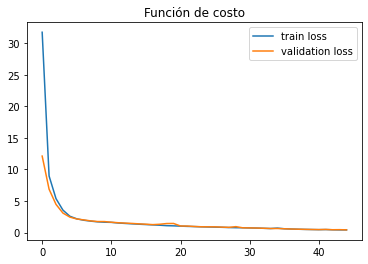

In [ ]:
plt.plot(train_loss[:], label = "train loss")
plt.plot(val_loss[:], label = "validation loss")
plt.title("Función de costo")
plt.legend()
plt.show()

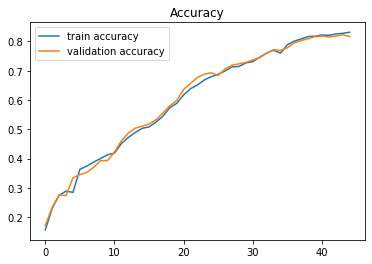

In [ ]:
plt.plot(train_ac, label = "train accuracy")
plt.plot(val_ac, label = "validation accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()